In [1]:
import response_utils
import adv_diff
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import expm
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

## 2D (space + time) Advection-Diffusion PDE
### $\frac{\partial T(x,t)}{\partial t} = \mu \frac{\partial^2 T(x,t)}{\partial x^2} - a_x \frac{\partial T(x,t)}{\partial x} + F(t)$,
where $T(t)$ is the temperature, $F(t)$ is the forcing, $\mu$ is the diffusivity, and $a_x$ is the advection speed. This form assumes a divergence-free velocity field and a constant, scalar viscous tensor.

We require two boundary conditions and one initial condition to fully characterize this PDE. We choose periodic BCs, $T(x=0,t) = T(x=L,t)$ And an initial condition of $T(x,t=0) = T_0 + \sin(\pi x/L)$.

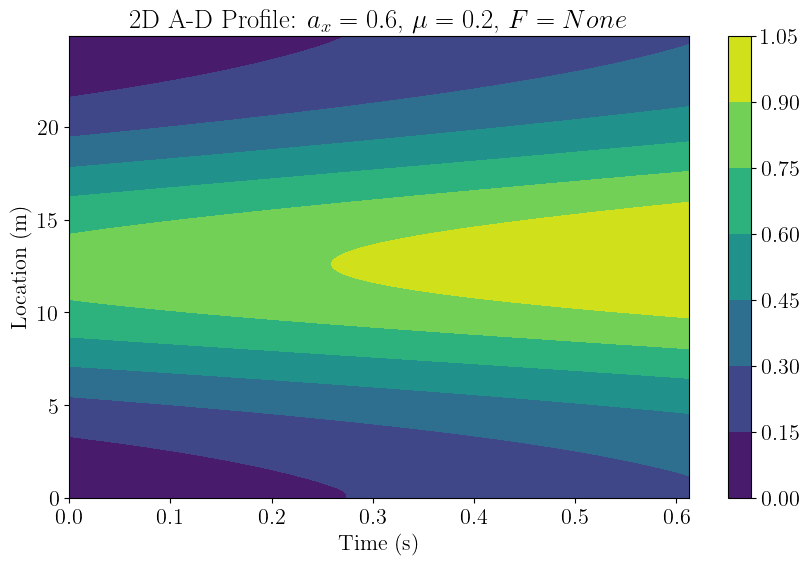

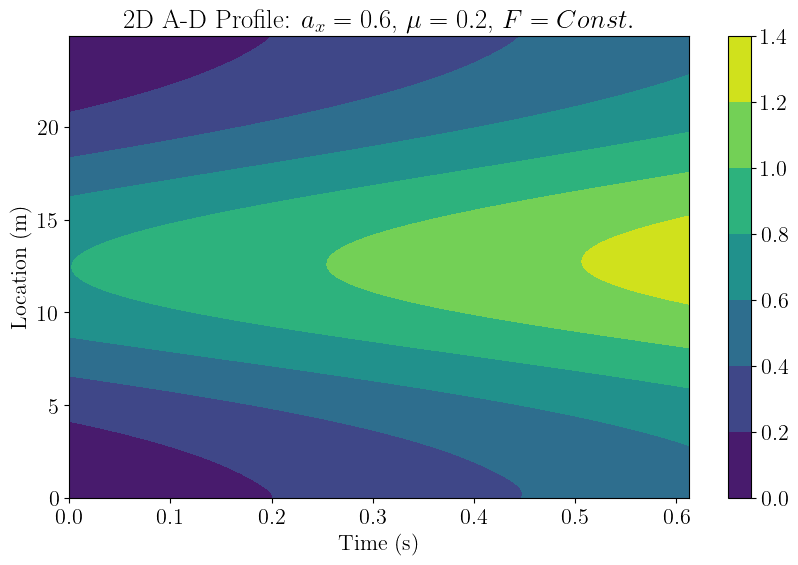

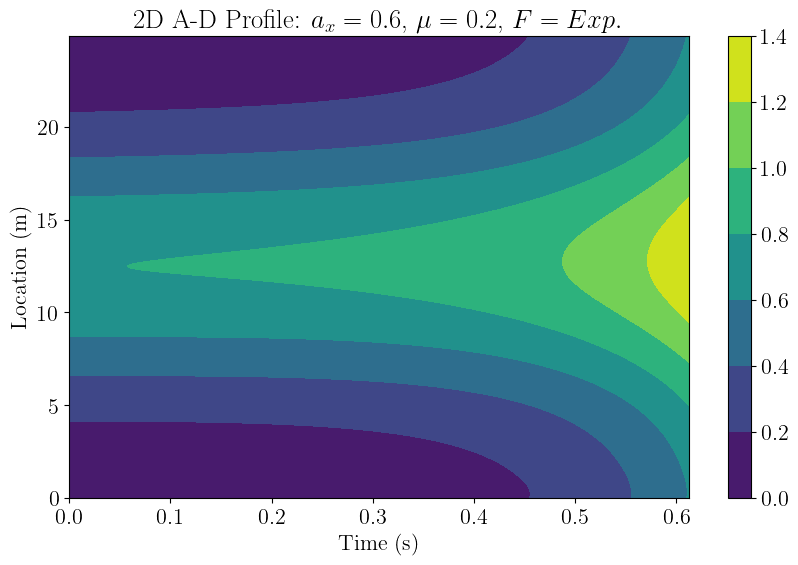

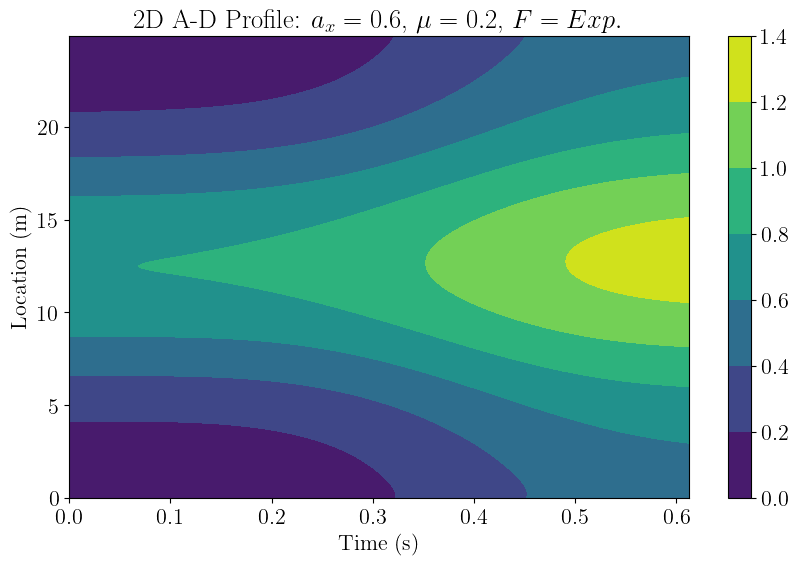

In [6]:
# ODE parameters
ax = 3/5
mu = 1/5
T0 = 5
F0 = 0.5

# Grid parameters
dx = 0.1
dt = adv_diff.calc_dt_2D(ax, mu, dx)
N_x = 250
N_t = 50
x_final = N_x*dx
t_final = N_t*dt
x = np.arange(0, x_final, dx)
t = np.arange(0, t_final, dt)
t_mesh, x_mesh = np.meshgrid(t, x)

# Initial condition
ic_sin = T0 + np.sin(2 * np.pi * x / x_final)

# Forcing profiles
F_none = response_utils.F_none(t)
F_const = response_utils.F_const(t, 0.1)
a, ts = 1/100, t_final
F_exp = response_utils.F_exp(t, a, ts)
F_del = response_utils.F_del(t, F0)

# Forcing parameters
## 2xCO2 and 4xCO2 (constant forcing)
F_2xCO2 = response_utils.F_const(t, 0.4)
F_4xCO2 = response_utils.F_const(t, 0.8)

## RCP70
F_final = 1 # (W m^-2)
ts = t_final/5
a_exp = F_final/np.exp(N_t/1.5*dt/ts)
F_exp = response_utils.F_exp(t, a_exp, ts)

## Overshoot
a_over = 1.6
b_over = t_final*(3/5)
c_over = ts
F_over = response_utils.F_over(t, a_over, b_over, c_over)

mn = np.mean(x)
std = 5
ic_gauss = (10 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mn) / std) ** 2)

# Initialize problem
t_mesh, x_mesh, T_sin = adv_diff.init_adv_diff_2D(ax, mu, T0, x, t, x_final, ic_gauss, plot_ic = False)

# Solve problem, calculate modes
T_none = adv_diff.adv_diff_2D_periodic(T_sin, ax, mu, dx, dt, N_t, t_mesh, x_mesh, F_2xCO2, 'None', plot_soln = True)
g_none, a_none = response_utils.calc_modes_2D(T_none)
T_const = adv_diff.adv_diff_2D_periodic(T_sin, ax, mu, dx, dt, N_t, t_mesh, x_mesh, F_4xCO2, 'Const.', plot_soln = True)
g_const, a_const = response_utils.calc_modes_2D(T_const)
T_exp = adv_diff.adv_diff_2D_periodic(T_sin, ax, mu, dx, dt, N_t, t_mesh, x_mesh, F_exp, 'Exp.', plot_soln = True)
g_exp, a_exp = response_utils.calc_modes_2D(T_exp)
T_over = adv_diff.adv_diff_2D_periodic(T_sin, ax, mu, dx, dt, N_t, t_mesh, x_mesh, F_over, 'Exp.', plot_soln = True)


g_const_sub, a_const_sub = response_utils.calc_modes_2D(T_const - T_none)
g_exp_sub, a_exp_sub = response_utils.calc_modes_2D(T_exp - T_none)

# Set up vectors for plotting/analysis
F_vec = [F_none, F_const, F_exp]
T_vec = [T_none, T_const, T_exp]
labels = ['$F = 0$', '$F = Const.$','$F = Exp.$']

### Method 1: Direct derivation using an impulse forcing

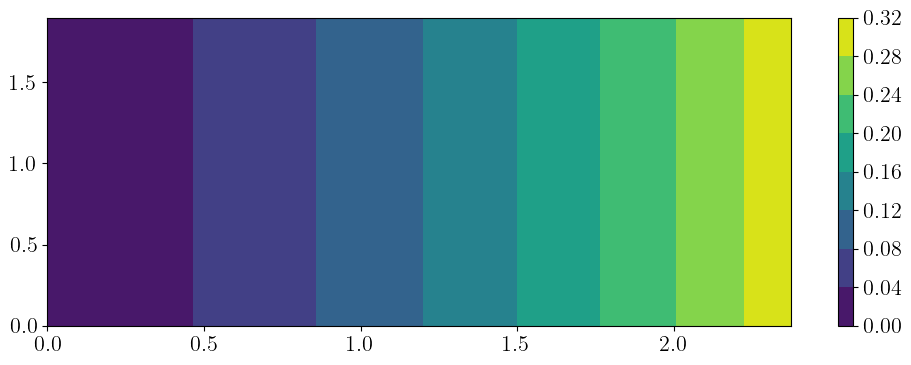

In [30]:
from scipy.signal import convolve
T_est = convolve(G_raw*dt, F_vec[1].reshape(1,len(F_vec[1])))[:, :len(F_vec[1])]
#plt.contourf(t_mesh, x_mesh, T_est)
plt.contourf(t_mesh, x_mesh, (T_exp - T_none))
#plt.contourf(t_mesh, x_mesh, T_est - (T_exp - T_none), cmap='coolwarm')
plt.colorbar()

Error from raw estimation.
	L2 Error, $F = Const.$: 20.68752
	L2 Error, $F = Exp.$: 3.00693
Avg. L2 Error: 11.84722

Error from modal estimation.
	L2 Error, $F = Const.$: 23.76261
	L2 Error, $F = Exp.$: 3.45505
Avg. L2 Error: 13.60883



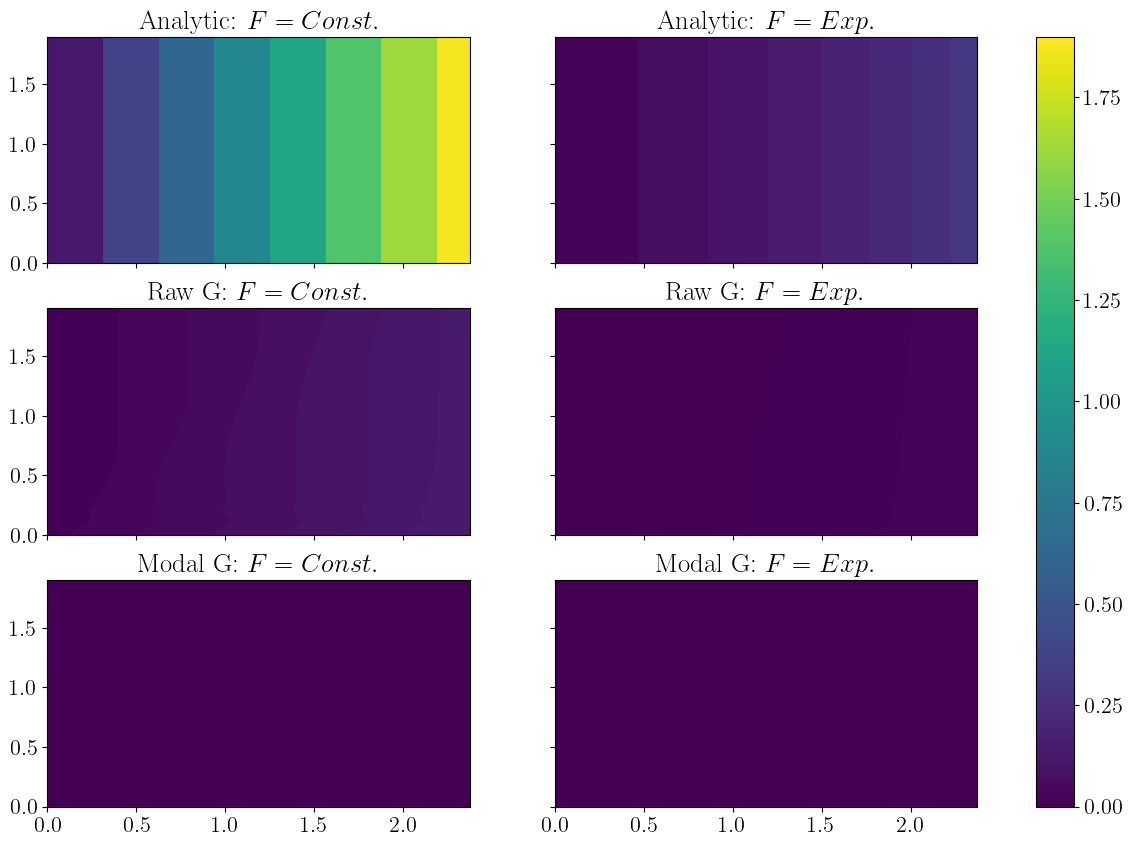

In [29]:
# Calculate G
mode = 'G'
G_raw = np.zeros((len(t), len(x)))

for i in range(N_x):
  ic_pulse = np.zeros(len(x))
  ic_pulse[i] = 1
  t_mesh, x_mesh, T_zero = adv_diff.init_adv_diff_2D(ax, mu, T0, x, t, x_final, ic_pulse, plot_ic = False)
  G_raw[:,i] = adv_diff.adv_diff_2D_periodic(T_zero, ax, mu, dx, dt, N_t, t_mesh, x_mesh, F_del, r'\delta(t)', plot_soln = False)[:,i]

g_del, G_modal = response_utils.calc_modes_2D(G_raw)
L2_raw, L2_modal = response_utils.plot_response_2D(T_vec, F_vec, labels, t_mesh, x_mesh, mode, G_raw, G_modal, T0, g_none, dt)

### Method 2: Direct inference of linear operator from data

Error from raw estimation.
	L2 Error, $F = 0$: 19.3037
	L2 Error, $F = Const.$: 0.37185
	L2 Error, $F = Exp.$: 16.51309
Avg. L2 Error: 12.06288

Error from modal estimation.
	L2 Error, $F = 0$: 23.14612
	L2 Error, $F = Const.$: 4.57224
	L2 Error, $F = Exp.$: 20.37763
Avg. L2 Error: 16.032



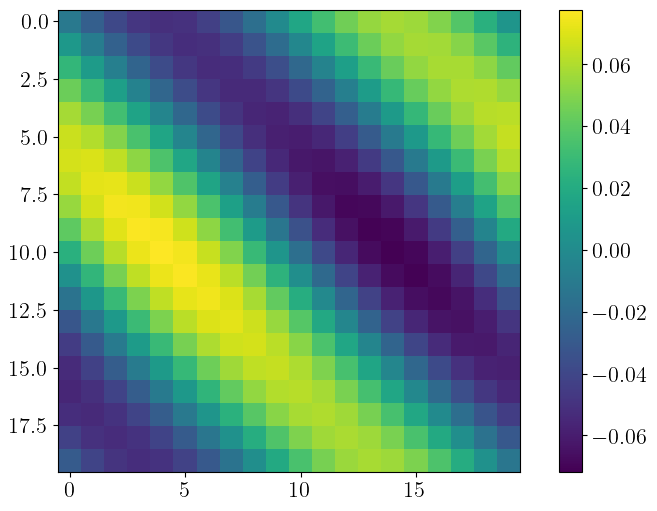

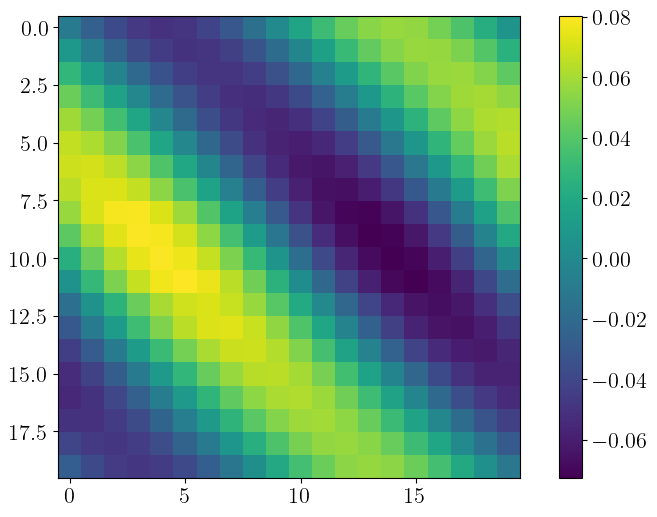

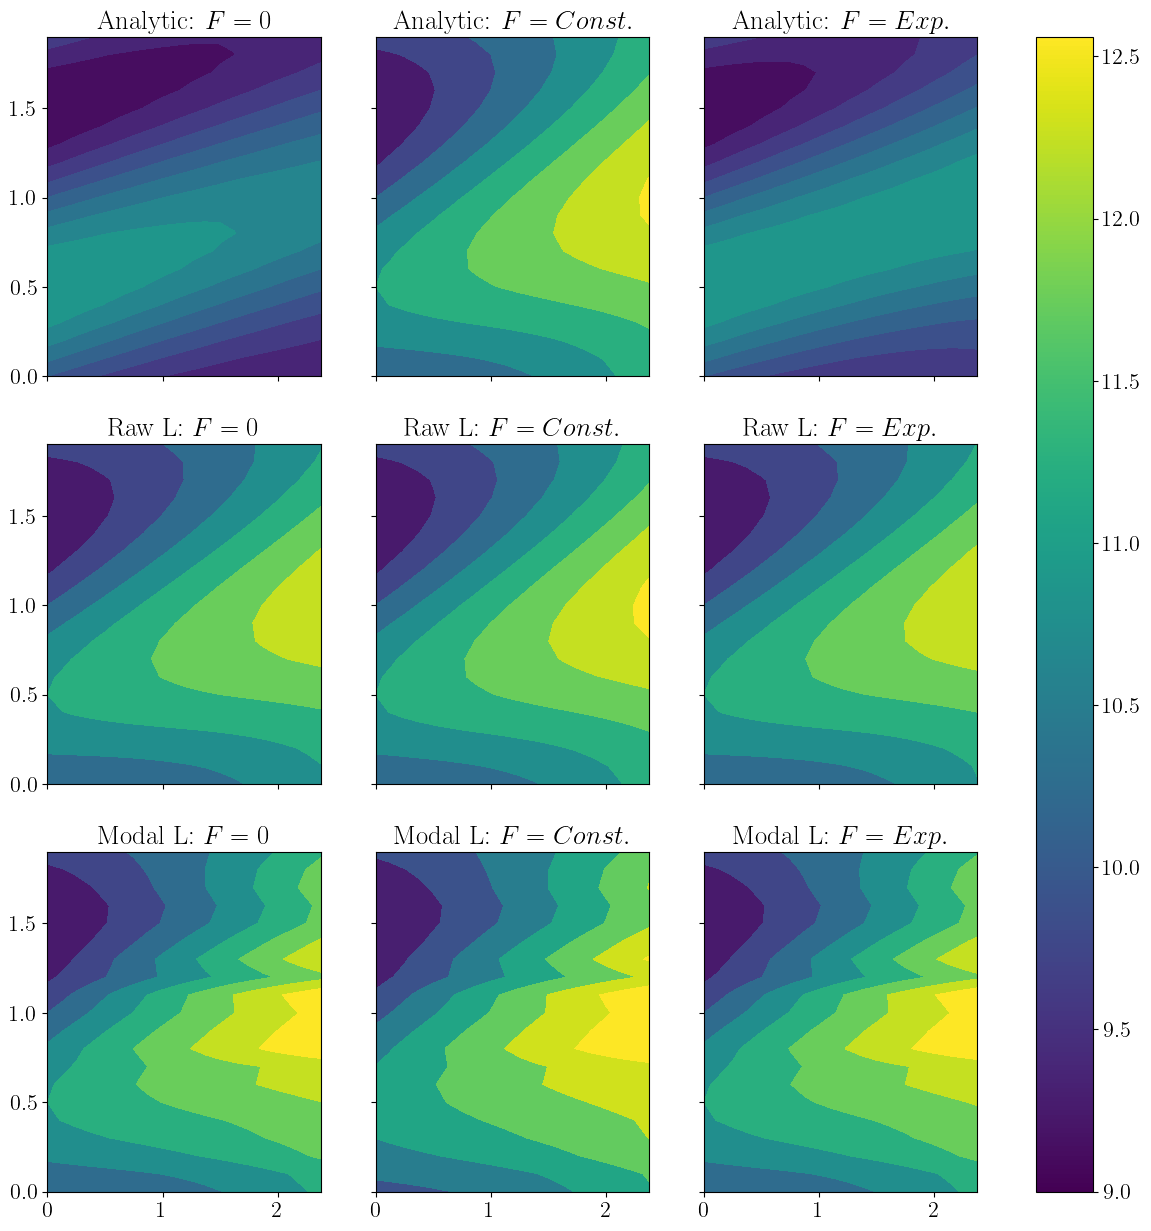

In [31]:
# Calculate L
mode = 'L'

L_raw_none = response_utils.calc_L_direct_2D(T_none, F_none, t, plot_L = False)
L_modal_none = response_utils.calc_L_direct_2D(a_none, F_none, t, modal=True, g=g_none, plot_L = False)
L_raw_const = response_utils.calc_L_direct_2D(T_const, F_const, t, plot_L = True)
L_modal_const = response_utils.calc_L_direct_2D(a_const, F_const, t, modal=True, g=g_const, plot_L = True)
L_raw_exp = response_utils.calc_L_direct_2D(T_exp, F_exp, t, plot_L = False)
L_modal_exp = response_utils.calc_L_direct_2D(a_exp, F_exp, t, modal=True, g=g_exp, plot_L = False)

L2_raw, L2_modal = response_utils.plot_response_2D(T_vec, F_vec, labels, t_mesh, x_mesh, mode, L_raw_const, L_modal_const, ic_sin, g_none, dt)

In [46]:
np.shape()

(1, 20)

In [53]:
np.shape(exp_Lt_stack)

(20, 20, 20)

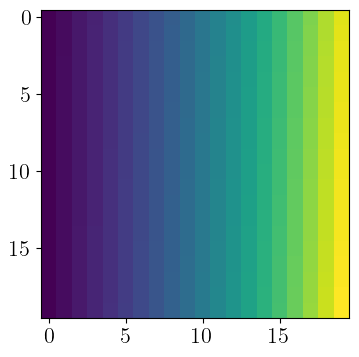

In [55]:
#G = np.dot(expm(L_raw_exp), np.ones((1,len(x))))
#plt.imshow(G)

# gamma(x') is a vector of ones, with the same length as L's dimension
gamma = np.ones(L_raw_exp.shape[1])

# Stack L to create a 3D array with shape (len(t_values), m, m)
# Each "slice" along the first axis corresponds to L * t_i for each time t_i
L_t_stack = np.einsum('ij,k->kij', L_raw_exp, t)

# Apply expm for each L(x,x') * t_i along the first axis
exp_Lt_stack = np.array([expm(Lt) for Lt in L_t_stack])

# Multiply each exp(L(x,x') * t_i) matrix by gamma
R_stack = np.einsum('kij,j->ki', exp_Lt_stack, gamma)

T_est = convolve(R_stack*dt, F_vec[2].reshape(1,len(F_vec[2])))[:, :len(F_vec[2])]
plt.imshow(T_est)

### Method 3: Direct deconvolution of response function from data

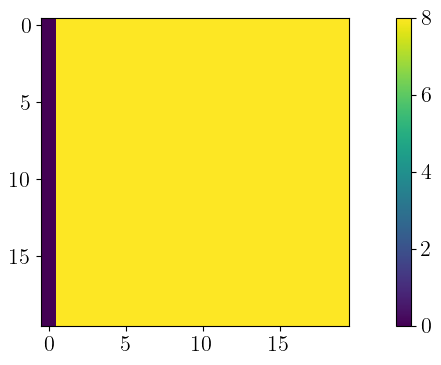

In [37]:
plt.imshow(G_raw)
plt.colorbar()

Error from raw estimation.
	L2 Error, $F = Const.$: 0.0
	L2 Error, $F = Exp.$: 0.0
Avg. L2 Error: 0.0

Error from modal estimation.
	L2 Error, $F = Const.$: 0.0
	L2 Error, $F = Exp.$: 0.0
Avg. L2 Error: 0.0



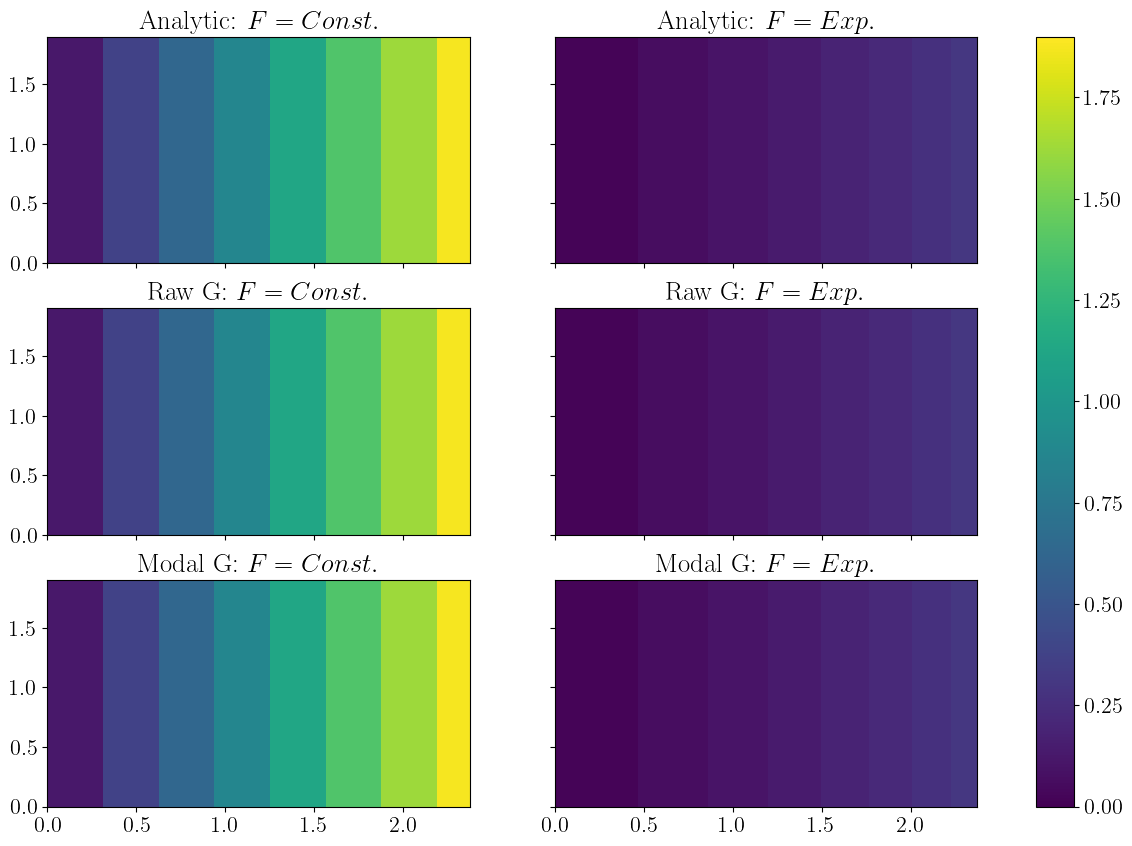

In [32]:
mode = 'G'
G_raw = response_utils.calc_G_deconv_2D(T_const - T_none, F_const, dt)
G_modal = response_utils.calc_G_deconv_2D(a_exp_sub, F_exp, dt)
L2_raw, L2_modal = response_utils.plot_response_2D(T_vec, F_vec, labels, t_mesh, x_mesh, mode, G_raw, G_modal, T0, g_exp_sub, dt)

### Method 4: Estimating response function with only leading timescales 

Error from raw estimation.
	L2 Error, $F = Const.$: 22.07651
	L2 Error, $F = Exp.$: 3.20885
Avg. L2 Error: 12.64268

Error from modal estimation.
	L2 Error, $F = Const.$: 22.26004
	L2 Error, $F = Exp.$: 3.23615
Avg. L2 Error: 12.74809



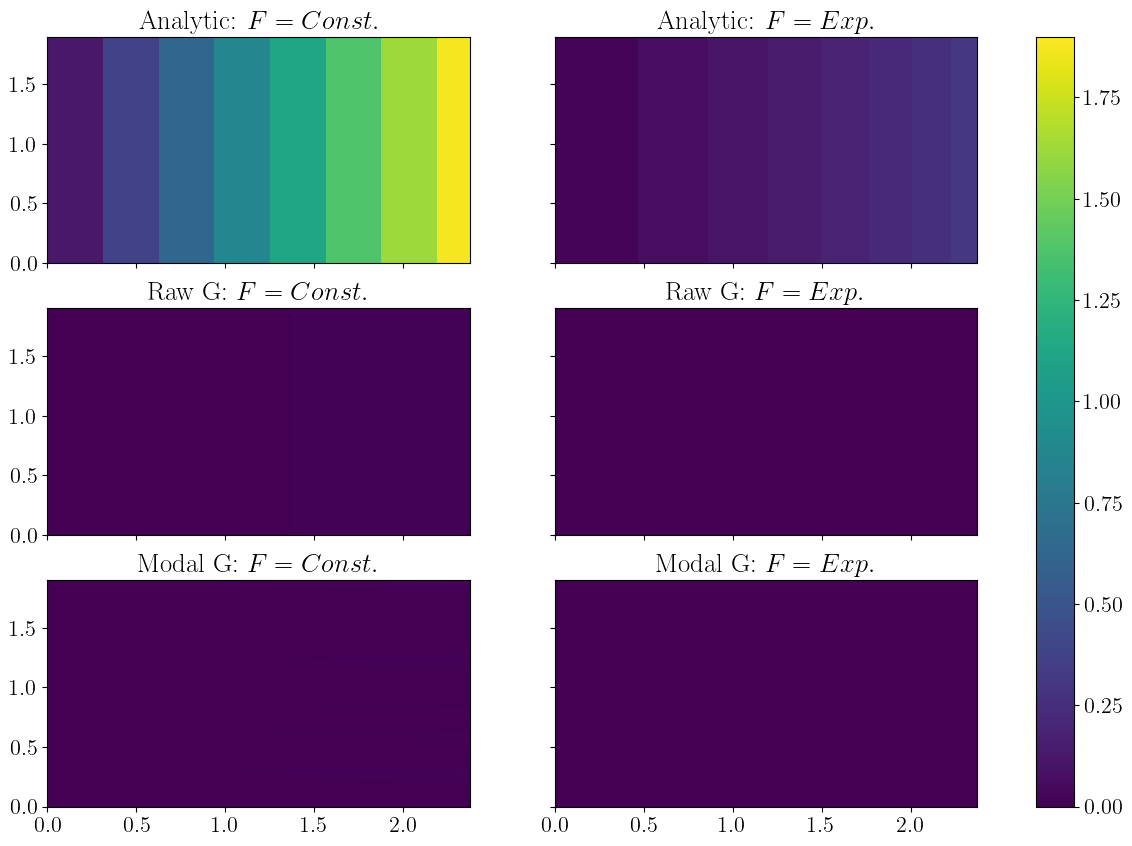

In [33]:
m = len(x)
initial_h = np.ones(m)
initial_lam = 1.0
initial_guess = np.concatenate([initial_h, [initial_lam]])
bounds = [(None, None)] * m + [(1e-10, 0.9999999999)]
options = {'disp': False}

res_raw = minimize(response_utils.opt_h_lam_2D,
              initial_guess,
              args=(T_const - T_none, F_const, t, m, dt),
              bounds=bounds,
              options=options)

G_opt_raw = response_utils.apply_response_2D(res_raw.x, t, m)

L2_raw, L2_modal = response_utils.plot_response_2D(T_vec, F_vec, labels, t_mesh, x_mesh, mode, G_opt_raw, G_opt_raw, T0, g_exp_sub, dt)